# Projective algorithm 

In this example we use the [pyALF](https://git.physik.uni-wuerzburg.de/ALF/pyALF) interface to run ALF's projective algorithm with the Mz choice of Hubbard Stratonovich transformation on a 4-site ring.

The projective approach is the method of choice if  one is interested in ground-state properties. The starting point is a pair of trial wave functions,  $|\Psi_{T,L/R} \rangle$,  that are  not orthogonal to the ground state $|\Psi_0 \rangle$:
$$
  \langle \Psi_{T,L/R}  | \Psi_0 \rangle  \neq 0. 
$$
The ground-state expectation value of  any  observable  $\hat{O}$ can then be computed by  propagation along the imaginary time axis:
$$
	 \frac{ \langle \Psi_0 | \hat{O} | \Psi_0 \rangle }{ \langle \Psi_0 | \Psi_0 \rangle}   = \lim_{\theta \rightarrow \infty}  
	 \frac{ \langle \Psi_{T,L} | e^{-\theta \hat{H}}  e^{-(\beta - \tau)\hat{H}  }\hat{O} e^{- \tau  \hat{H} }   e^{-\theta \hat{H}} | \Psi_{T,R} \rangle } 
	        { \langle \Psi_{T,L} | e^{-(2 \theta + \beta) \hat{H}  } | \Psi_{T,R} \rangle } ,
$$
where $\beta$ defines the imaginary time range where observables (time displaced and equal time) are measured and $\tau$ varies from $0$ to $\beta$ in the calculation of time-displace observables. For further details, see Sec. 3 of [ALF documentation](https://git.physik.uni-wuerzburg.de/ALF/ALF/-/blob/master/Documentation/doc.pdf).

---

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF, as well as numerical and plotting packages:

In [1]:
from py_alf import Simulation, ALF_source # Interface with ALF
# 
import numpy as np                        # Numerical library
from scipy.optimize import curve_fit      # Numerical library
import matplotlib.pyplot as plt           # Plotting library

In [2]:
alf_src = ALF_source(
    branch='196-write-parameters-to-hdf5-file', # TODO: Remove this after merging '196-write-parameters-to-hdf5-file' into master
)

Checking out branch 196-write-parameters-to-hdf5-file


 **2.** Create instances of `Simulation`, specifying the necessary parameters, in particular the `Projector` to `True`:

In [3]:
sims = []                                # Vector of Simulation instances
print('Theta values used:')
for theta in [1, 2, 5, 10, 15]:                # Values of Theta
    print(theta)
    sim = Simulation(
        alf_src,
        'Hubbard',                       # Hamiltonian
        {                                # Model and simulation parameters for each Simulation instance
        'Model': 'Hubbard',              #    Base model
        'Lattice_type': 'N_leg_ladder',  #    Lattice type
        'L1': 4,                         #    Lattice length in the first unit vector direction
        'L2': 1,                         #    Lattice length in the second unit vector direction
        'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
        'Symm': True,                    #    Whether symmetrization takes place
        'Projector': True,               #    Whether to use the projective algorithm
        'Theta': theta,                  #    Projector parameter
        'ham_T': 1.0,                    #    Hopping parameter
        'ham_U': 4.0,                    #    Hubbard interaction
        'ham_Tperp': 0.0,                #    For bilayer systems
        'beta': 1.0,                     #    Inverse temperature
        'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
        'NSweep': 600,                   #    Number of sweeps per bin
        'NBin': 50,                      #    Number of bins
        'Dtau': 0.05,                    #    Only dtau varies between simulations, Ltrot=beta/Dtau
        'Mz': True,                      #    If true, sets the M_z-Hubbard model: Nf=2, N_sum=1,
        },                               #             HS field couples to z-component of magnetization
    )
    sims.append(sim)

Theta values used:
1
2
5
10
15


**3.** Compile ALF, downloading it first if not found locally. This may take a few minutes:

In [4]:
sims[0].compile()                        # Compilation needs to be performed only once

Compiling ALF... 
Done.


**4.** Perform the simulations, as specified in each element of `sim`:

In [5]:
for i, sim in enumerate(sims):
    sim.run()                            # Perform the actual simulation in ALF

Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_Projector=True_Theta=1_T=1.0_U=4.0_Tperp=0.0_beta=1.0_Dtau=0.05_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/ALF/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_Projector=True_Theta=2_T=1.0_U=4.0_Tperp=0.0_beta=1.0_Dtau=0.05_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/ALF/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_Projector=True_Theta=5_T=1.0_U=4.0_Tperp=0.0_beta=1.0_Dtau=0.05_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/ALF/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_Projector=True_Theta=10_T=1.0_U=4.0_Tperp=0.0_b

**5.** Calculate the internal energies:

In [6]:
%%capture
ener = np.empty((len(sims), 2))          # Matrix for storing energy values
thetas = np.empty((len(sims),))          # Matrix for Thetas values, for plotting
for i, sim in enumerate(sims):
    print(sim.sim_dir)                   # Directory containing the simulation output
    sim.analysis()                       # Perform default analysis
    thetas[i] = sim.sim_dict['Theta']                        # Store Theta value
    obs = sim.get_obs()
    ener[i] = obs.iloc[0][['Ener_scal0', 'Ener_scal0_err']]  # Store energy value

Where the _cell magic_ `%%capture` suppresses the output of `sim.analysis()`, which lists the data directories and observables.

In [7]:
print('For Theta values', thetas, 'the measured energies are:\n', ener)

For Theta values [ 1.  2.  5. 10. 15.] the measured energies are:
 [[-2.10506041  0.00479326]
 [-2.10919187  0.00738796]
 [-2.11249369  0.00743174]
 [-2.11180142  0.0098494 ]
 [-2.10817133  0.0064047 ]]


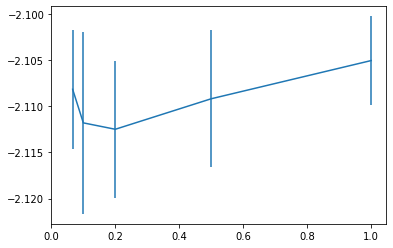

In [8]:
plt.errorbar(1/thetas, ener[:, 0], ener[:, 1]); plt.xlim(0, );

---
## Exercises
1. A ladder system consists of chains assembled one next to the other, for instance, setting `L1=14`, `L2=3` defines a 3-leg ladder. It is a well-known result ([Dagotto and Rice, _Science_ 271 (1996), **5249**, pp. 618](doi.org/10.1126/science.271.5249.618)) that spin correlations in ladder systems decay as power laws (apart from logarithmic corrections) for odd-leg ladders, and exponentially for even-leg ladders. The paper presents numerical results for the Heisenberg model. How do these correlations behave for the Hubbard model at half-filling?